In [27]:
# Пример транслитерации (можно заменить на необходимый перевод)
translit_dict = {
    'A': 'А', 'B': 'Б', 'C': 'Ц', 'D': 'Д', 'E': 'Е', 'F': 'Ф', 'G': 'Г', 'H': 'Х',
    'I': 'И', 'J': 'Й', 'K': 'К', 'L': 'Л', 'M': 'М', 'N': 'Н', 'O': 'О', 'P': 'П',
    'Q': 'К', 'R': 'Р', 'S': 'С', 'T': 'Т', 'U': 'У', 'V': 'В', 'W': 'В', 'X': 'КС', 'Y': 'Й',
    'Z': 'З',
    'a': 'а', 'b': 'б', 'c': 'ц', 'd': 'д', 'e': 'е', 'f': 'ф', 'g': 'г', 'h': 'х',
    'i': 'и', 'j': 'й', 'k': 'к', 'l': 'л', 'm': 'м', 'n': 'н', 'o': 'о', 'p': 'п',
    'q': 'к', 'r': 'р', 's': 'с', 't': 'т', 'u': 'у', 'v': 'в', 'w': 'в', 'x': 'кс', 'y': 'й',
    'z': 'з', 'á': 'а', 'à': 'а', 'ä': 'а',
    'é': 'е', 'è': 'е',
    'í': 'и', 'ì': 'и',
    'ó': 'о', 'ò': 'о',
    'ú': 'у', 'ù': 'у',
    'ö': 'о', 'ü': 'у',
    'ß': 'с', 'ç': 'ц', 'ê': 'е','É': 'Е',
}


In [81]:
import pandas as pd
import os
import zipfile
from collections import Counter
import re
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [61]:
# Функция для ручного one-hot кодирования
def one_hot_encode(char, unique_chars):
    # Создаем словарь для кодирования символов
    char_to_index = {char: idx for idx, char in enumerate(unique_chars)}

    # Получаем индекс символа
    index = char_to_index.get(char, -1)  # Если символа нет, вернем -1

    # Создаем нулевой вектор
    one_hot_vector = [0] * len(unique_chars)

    # Устанавливаем 1 на позиции индекса, если символ найден
    if index != -1:
        one_hot_vector[index] = 1

    return one_hot_vector

# Кодирование фамилий с использованием ручного one-hot
def encode_surname(surname):
    surname_encoded = [one_hot_encode(char, unique_chars) for char in surname]

    while len(surname_encoded) < max_len:  # Дополнение до max_len
      surname_encoded.insert(0, [0] * len(unique_chars))

      # Добавляем пустой (нулевой) вектор

    return surname_encoded[:max_len]  # Обрезаем до max_len по необходимости

def transliterate(text):
    return ''.join(translit_dict.get(char, char) for char in text)

In [62]:
data = []

with zipfile.ZipFile('names.zip', 'r') as zip_ref:
    names_files = [name for name in zip_ref.namelist() if name.endswith('.txt')]  # Берем только первые 8 файлов
    for filename in names_files:
        nationality = os.path.splitext(os.path.basename(filename))[0]
        with zip_ref.open(filename) as file:
            surnames = []
            for i, line in enumerate(file):
                surnames.append(line.decode('utf-8').strip())# Убираем лишние пробелы и декодируем

            for surname in surnames:
                data.append((transliterate(surname), nationality))

data = pd.DataFrame(data, columns=['Surname', 'Nationality'])


In [63]:
data

,Surname,Nationality
0,Кхоурй,Arabic
1,Нахас,Arabic
2,Дахер,Arabic
3,Гергес,Arabic
4,Назари,Arabic
...,...,...
20069,Труонг,Vietnamese
20070,Ван,Vietnamese
20071,Винх,Vietnamese
20072,Вуонг,Vietnamese


In [64]:
max_len = max(data['Surname'].apply(len))  # Находим максимальную длину фамилии
unique_chars = sorted(set(''.join(data['Surname'].values)))
char_encoder = {char: idx for idx, char in enumerate(unique_chars)}  # Создаем словарь с кодировкой букв

In [65]:
top10_nationalities = data.groupby(['Nationality']).count().sort_values(['Surname'], ascending = False).head(10).index.to_list()
data = data[data['Nationality'].isin(top10_nationalities)].dropna()

In [66]:
data

,Surname,Nationality
0,Кхоурй,Arabic
1,Нахас,Arabic
2,Дахер,Arabic
3,Гергес,Arabic
4,Назари,Arabic
...,...,...
19996,Заморано,Spanish
19997,Запатеро,Spanish
19998,Завала,Spanish
19999,Зубизаррета,Spanish


In [67]:
data['Surname_enc'] = data['Surname'].apply(encode_surname)  # Кодируем все фамилии
X = np.array(data['Surname_enc'].tolist())

In [68]:
X = np.array(data['Surname_enc'].tolist())
le = LabelEncoder()
y = le.fit_transform(data['Nationality'])  # Переводим метки национальностей в числа
# Преобразуем в one-hot кодирование вручную
y_one_hot = np.eye(len(le.classes_))[y]  # Создаем one-hot кодирование для национальностей.
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
num_classes = y_one_hot.shape[1]

In [69]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(max_len, len(unique_chars)), return_sequences=False))
lstm_model.add(Dense(units=64, activation='relu'))  # Теперь 64 юнита
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10


/home/dream_on/miniconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5900 - loss: 1.2897 - val_accuracy: 0.6857 - val_loss: 1.0060
Epoch 2/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7012 - loss: 0.9232 - val_accuracy: 0.7264 - val_loss: 0.8519
Epoch 3/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7504 - loss: 0.7850 - val_accuracy: 0.7565 - val_loss: 0.7467
Epoch 4/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7700 - loss: 0.7148 - val_accuracy: 0.7837 - val_loss: 0.7033
Epoch 5/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7845 - loss: 0.6714 - val_accuracy: 0.7909 - val_loss: 0.6828
Epoch 6/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7996 - loss: 0.6354 - val_accuracy: 0.7959 - val_loss: 0.6621
Epoch 7/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8089 - loss: 0.6025 - val_accuracy: 0.7985 - val_loss: 0.6460
Epoch 8/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8168 - loss: 0.5723 - val_accuracy: 0.802

In [91]:
user_surname = input("Введите фамилию на кириллице: ")
encoded_input = np.array([encode_surname(transliterate(user_surname))])

all_frequencies = lstm_model.predict(encoded_input)

predicted_classes = np.argsort(all_frequencies)[0]  # Получаем индексы 5 наибольших вероятностей
top_nationalities = le.inverse_transform(predicted_classes).tolist()[::-1]  # Преобразование обратно в названия национальностей
top_frequencies = all_frequencies[0][predicted_classes].tolist()[::-1]  # Частоты для этих классов

print("\nВероятности предсказанных национальностей: ")
for i in range(len(predicted_classes)):
    print(f"{top_nationalities[i]}: {top_frequencies[i]:.2%}")

Введите фамилию на кириллице:  Гонзалес


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Вероятности предсказанных национальностей: 
Dutch: 21.38%
German: 21.18%
Russian: 16.78%
Spanish: 16.37%
English: 8.83%
French: 8.38%
Czech: 3.68%
Arabic: 2.53%
Italian: 0.84%
Japanese: 0.02%


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


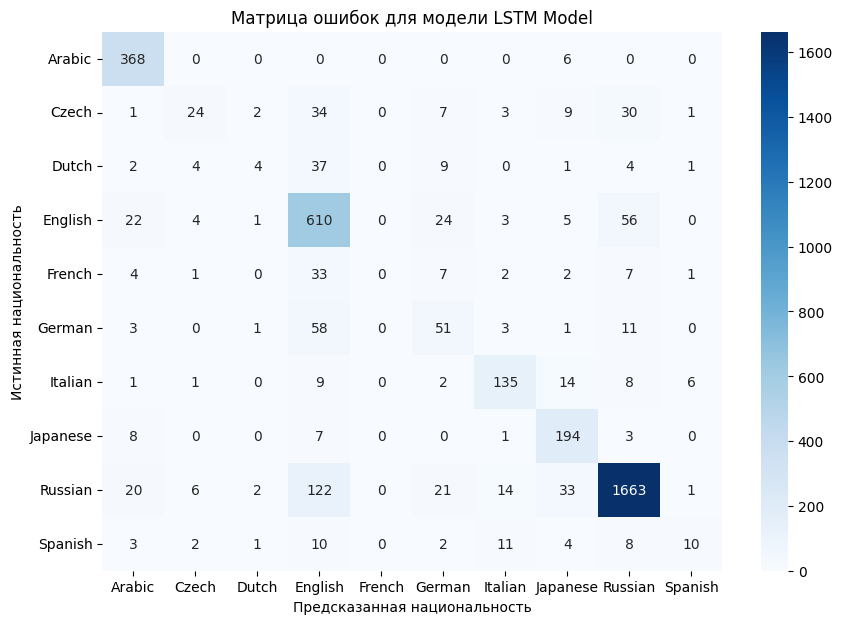

In [80]:
# 7. Прогнозирование на тестовом множестве для LSTM
lstm_y_pred = lstm_model.predict(X_test)
lstm_y_pred_classes = np.argmax(lstm_y_pred, axis=1)

y_true_classes = np.argmax(y_test, axis=1) # Преобразование истинных меток из OHE обратно в классы

# 8. Создание матриц ошибок
lstm_conf_matrix = confusion_matrix(y_true_classes, lstm_y_pred_classes)

# Визуализация матриц ошибок
def plot_confusion_matrix(conf_matrix, classes, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Матрица ошибок для модели {model_name}')
    plt.ylabel('Истинная национальность')
    plt.xlabel('Предсказанная национальность')
    plt.show()
plot_confusion_matrix(lstm_conf_matrix, le.classes_, "LSTM Model")